In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("fareselmenshawii/face-detection-dataset")

# print("Path to dataset files:", path)

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.nn as nn

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
project_root_dir= os.getcwd() + "/../"
data_dir= project_root_dir + "data/"
images_train_dir= data_dir + "images/train/"
images_val_dir= data_dir + "images/val/"
labels_train_dir= data_dir + "labels/train/"
labels_val_dir= data_dir + "labels/val/"

(681, 1024)

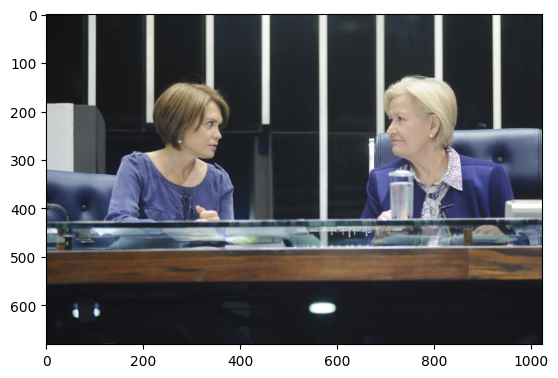

In [4]:
image= cv2.imread(images_train_dir + "00a0d634ad200ced.jpg", cv2.IMREAD_COLOR)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
height, width = image.shape[:2]
image.shape[:2]

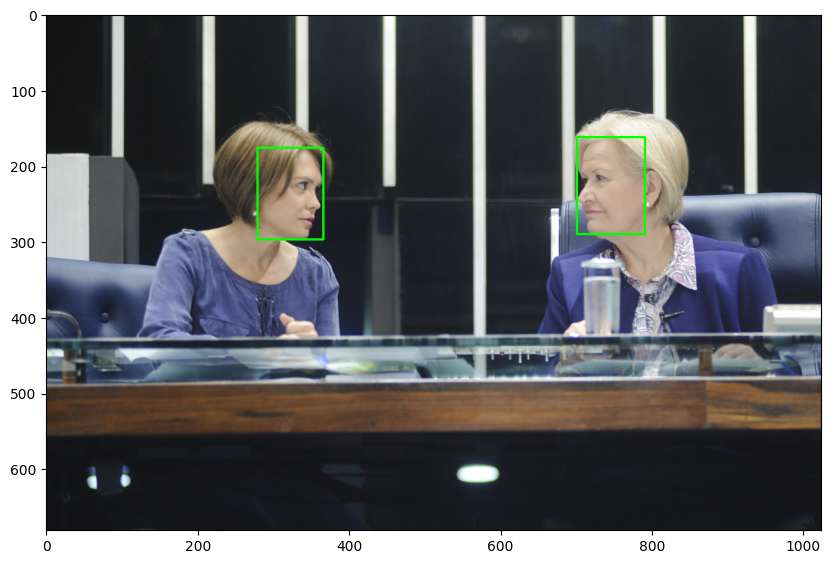

In [5]:
label_sample= labels_train_dir + "00a0d634ad200ced.txt" 
bounding_boxes= []
with open(label_sample, 'r') as f:
    for line in f:
        _, x, y, box_width, box_height= map(float, line.strip().split())
        x1 = int((x - box_width / 2) * width)
        y1 = int((y - box_height / 2) * height)
        x2 = int((x + box_width / 2) * width)
        y2 = int((y + box_height / 2) * height)
        box= list([x1, y1, x2, y2])
        bounding_boxes.append(box)

for box in bounding_boxes:
    xmin, ymin, xmax, ymax= map(int, box)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    
plt.figure(figsize= (10,8))
plt.imshow(image)

In [ ]:
def draw_image_with_box(image_tensor, bounding_boxes_tensor):
    np_image= image_tensor.detach().cpu().numpy()
    np_image= np.transpose(np_image, (1, 2, 0))
    if np_image.max() > 1.0:
        np_image= np_image / 255.0

    np_image= np.clip(np_image, 0.0, 1.0)
    np_image= (np_image * 255).astype(np.uint8)
    image_width, image_height= np_image.shape[:2]

    if not np_image.flags['C_CONTIGUOUS']:
        np_image= np.ascontiguousarray(np_image)
    
    np_boxes= bounding_boxes_tensor.detach().cpu().numpy()
    for box in np_boxes:
        xmin, ymin, xmax, ymax= box
        xmin= int(xmin * image_width)
        ymin= int(ymin * image_height)
        xmax= int(xmax * image_width)
        ymax= int(ymax * image_height)
        display_image= cv2.rectangle(np_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
    plt.figure(figsize= (10,5))
    plt.axis('off')
    plt.imshow(display_image)

In [7]:
valid_img_extensions= ('.jpg', '.jpeg', '.png')
all_images= [
    img for img in os.listdir(images_train_dir)
    if img.lower().endswith(valid_img_extensions) and os.path.exists(os.path.join(labels_train_dir, img.rsplit('.', 1)[0] + ".txt"))
]
all_images[1:5]


['998faa48943fce6f.jpg',
 'a228f997057aa291.jpg',
 '49fe432784afea63.jpg',
 '0106e273d2de08be.jpg']

In [8]:
class FaceDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_list, max_boxes= 5, transform= None):
        self.image_dir= image_dir
        self.label_dir= label_dir
        self.image_list= image_list
        self.transform= transform
        self.max_boxes= max_boxes

    def __len__(self):
        return len(self.image_list)
    def __getitem__(self, idx):
        
        image_name= self.image_list[idx]
        image_path= os.path.join(self.image_dir, image_name)
        label_path= os.path.join(self.label_dir, image_name.rsplit('.', 1)[0] + '.txt')

        image= cv2.imread(image_path)
        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width= image.shape[:2]
        bounding_boxes= []


        if self.transform:
            tensor_image= torch.from_numpy(image).permute(2, 0, 1).float()
            tensor_image= self.transform(tensor_image)
            resized_height, resized_width= tensor_image.shape[1:3]
            with open(label_path, 'r') as f:
                for line in f:
                    _, x, y, box_width, box_height= map(float, line.strip().split())
                    x1= int((x - box_width / 2) * resized_width)
                    y1= int((y - box_height / 2) * resized_height)
                    x2= int((x + box_width / 2) * resized_width)
                    y2= int((y + box_height / 2) * resized_height)
                    box= list([x1, y1, x2, y2])
                    bounding_boxes.append(box)
        else:
            tensor_image= torch.from_numpy(image).permute(2, 0, 1).float()
            with open(label_path, 'r') as f:
                for line in f:
                    _, x, y, box_width, box_height= map(float, line.strip().split())
                    x1= int((x - box_width / 2) * original_width)
                    y1= int((y - box_height / 2) * original_height)
                    x2= int((x + box_width / 2) * original_width)
                    y2= int((y + box_height / 2) * original_height)
                    box= list([x1, y1, x2, y2])
                    bounding_boxes.append(box)

        num_curr_boxes= len(bounding_boxes)
        if num_curr_boxes < self.max_boxes:
            padding= np.zeros((self.max_boxes - num_curr_boxes, 4), dtype= np.float32)
            padded_boxes= np.concatenate((np.array(bounding_boxes, dtype= np.float32),
                                           padding), axis= 0)
            
        else:
            padded_boxes= np.array(bounding_boxes[:self.max_boxes], dtype=np.float32)
        
        boxes_tensor= torch.tensor(padded_boxes, dtype= torch.float32)

        return {
            'image': tensor_image,
            'boxes': boxes_tensor
        }

In [9]:
train_images, val_images= train_test_split(all_images, test_size= 0.2, random_state= 42)
transforms= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Normalize(mean=(0.5,) * 3, std=(0.5,) * 3)
])
train_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir, image_list= train_images, max_boxes= 7, transform= transforms)
train_dataset[1]

{'image': tensor([[[352.0565, 352.8867, 360.1703,  ..., 310.4937, 312.1322, 317.5887],
          [357.4591, 350.7386, 352.0140,  ..., 307.6113, 307.7637, 313.3150],
          [359.0363, 354.8296, 360.0101,  ..., 317.0617, 310.3904, 312.4282],
          ...,
          [411.6109, 419.3404, 419.9554,  ..., 363.2943, 383.0967, 392.4502],
          [403.0862, 413.5461, 417.4562,  ..., 369.6827, 379.9071, 397.3633],
          [402.7126, 408.7515, 421.1537,  ..., 377.0258, 384.0236, 395.4594]],
 
         [[338.8630, 336.8812, 345.0944,  ..., 309.1349, 305.6900, 306.6149],
          [339.3872, 338.4984, 340.5155,  ..., 305.9809, 305.2375, 306.2781],
          [339.8438, 336.8338, 337.3852,  ..., 303.9751, 301.6772, 303.6800],
          ...,
          [442.3775, 445.9425, 443.2556,  ..., 378.2266, 396.6841, 411.5230],
          [425.7448, 433.5830, 441.4240,  ..., 382.3954, 403.6296, 417.9796],
          [424.5801, 433.7004, 450.4931,  ..., 389.6900, 411.0536, 424.5646]],
 
         [[214.8292

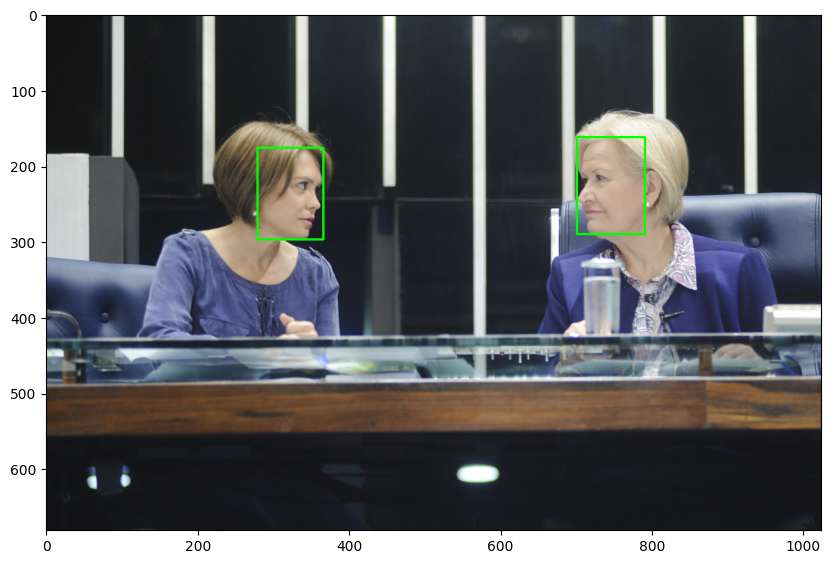

In [10]:
image= cv2.imread(images_train_dir + "00a0d634ad200ced.jpg", cv2.IMREAD_COLOR)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
label= labels_train_dir + "00a0d634ad200ced.txt"
original_bboxes= []
height, width= image.shape[:2]
with open(label, 'r') as f:
    for line in f:
        _, x, y, box_width, box_height= map(float, line.strip().split())
        x1= int((x - box_width / 2) * width)
        y1= int((y - box_height / 2) * height)
        x2= int((x + box_width / 2) * width)
        y2= int((y + box_height / 2) * height)
        box= list([x1, y1, x2, y2])
        original_bboxes.append(box)
for box in original_bboxes:
    xmin, ymin, xmax, ymax= map(int, box)
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
plt.figure(figsize= (10, 8))
plt.imshow(image)

torch.Size([681, 1024, 3])


torch.Size([3, 224, 224])

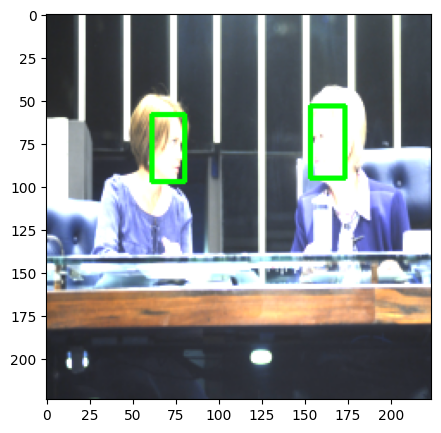

In [11]:
tensor_image= torch.from_numpy(image)
print(tensor_image.shape)
tensor_image= tensor_image.permute(2, 0, 1).float()
transformed_image= transforms(tensor_image)
height, width= transformed_image.shape[1:3]
transformed_bboxes= []
with open(label, 'r') as f:
    for line in f:
        _, x, y, box_width, box_height= map(float, line.strip().split())
        x1= int((x - box_width / 2) * width)
        y1= int((y - box_height / 2) * height)
        x2= int((x + box_width / 2) * width)
        y2= int((y + box_height / 2) * height)
        box= list([x1, y1, x2, y2])
        transformed_bboxes.append(box)
transformed_bboxes_tensor= torch.tensor(transformed_bboxes, dtype= torch.float32)

draw_image_with_box(transformed_image, transformed_bboxes_tensor)
transformed_image.shape

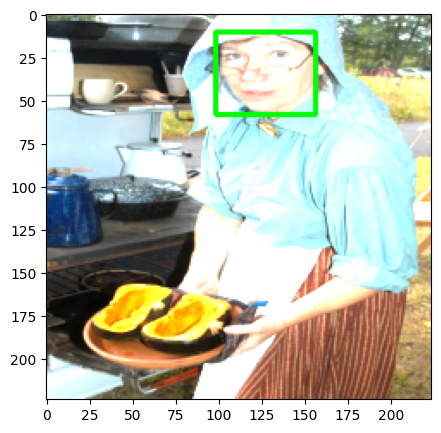

In [12]:
image_sample= train_dataset[20]['image']
boxes_sample= train_dataset[20]['boxes']
draw_image_with_box(image_sample, boxes_sample)

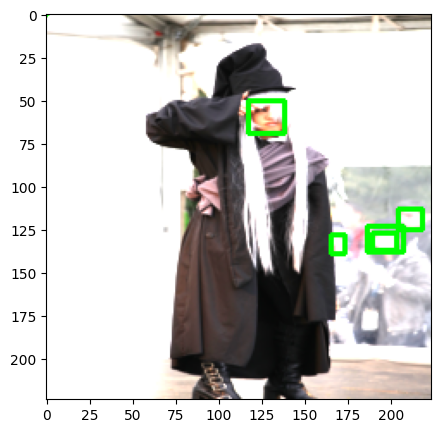

In [13]:
val_dataset= FaceDataset(image_dir= images_train_dir, label_dir= labels_train_dir,
                         image_list= val_images, max_boxes= 7, transform= transforms)
image_sample= val_dataset[2]['image']
boxes_sample= val_dataset[2]['boxes']
draw_image_with_box(image_sample, boxes_sample)

In [14]:
def generate_anchor_boxes(feature_map_shape, image_shape, scales, ratios, stride):

    feature_map_height, feature_map_width= feature_map_shape
    image_height, image_width= image_shape

    base_anchors_wh= []
    for scale in scales:
        for ratio in ratios:
            width= scale * np.sqrt(ratio)
            height= scale / np.sqrt(ratio)
            base_anchors_wh.append([width, height])
        
    base_anchors_wh= np.array(base_anchors_wh)
    num_base_anchors= base_anchors_wh.shape[0]

    

    center_x_coords= np.arange(feature_map_width) * stride + stride / 2.0
    center_y_coords= np.arange(feature_map_height) * stride + stride / 2.0


    center_y_grid, center_x_grid= np.meshgrid(center_y_coords, center_x_coords)
    centers_xy= np.stack([center_x_grid, center_y_grid], axis= -1) # Shape [16, 16, 2]
 
        
    centers_expanded= np.expand_dims(centers_xy, axis= 2) # Shape [16, 16, 1, 2]
    base_anchors_expanded= np.expand_dims(base_anchors_wh, axis= (0, 1)) # Shape [1, 1, 9, 2]
    grid_height, grid_width= centers_xy.shape[:2]
    all_anchors_xyxy_relative= np.zeros((grid_height, grid_width, num_base_anchors, 4), dtype= np.float32)

    all_anchors_xyxy_relative[:, :, :, 0]= centers_expanded[:, :, :, 0] - base_anchors_expanded[:, :, :, 0] / 2.0
    all_anchors_xyxy_relative[:, :, :, 1]= centers_expanded[:, :, :, 1] - base_anchors_expanded[:, :, :, 1] / 2.0

    all_anchors_xyxy_relative[:, :, :, 2]= centers_expanded[:, :, :, 0] + base_anchors_expanded[:, :, :, 0] / 2.0
    all_anchors_xyxy_relative[:, :, :, 3]= centers_expanded[:, :, :, 1] + base_anchors_expanded[:, :, :, 1] / 2.0

    all_anchors_xyxy_relative[:, :, :, 0]= np.clip(all_anchors_xyxy_relative[:, :, :, 0], 0, image_width - 1)
    all_anchors_xyxy_relative[:, :, :, 1]= np.clip(all_anchors_xyxy_relative[:, :, :, 1], 0, image_height - 1)
    all_anchors_xyxy_relative[:, :, :, 2]= np.clip(all_anchors_xyxy_relative[:, :, :, 2], 0, image_width - 1)
    all_anchors_xyxy_relative[:, :, :, 3]= np.clip(all_anchors_xyxy_relative[:, :, :, 3], 0, image_height - 1)

    all_anchors_xyxy_relative[:, :, :, 0]/= image_width
    all_anchors_xyxy_relative[:, :, :, 1]/= image_height
    all_anchors_xyxy_relative[:, :, :, 2]/= image_width
    all_anchors_xyxy_relative[:, :, :, 3]/= image_height

    all_anchors_xyxy= all_anchors_xyxy_relative.reshape(-1, 4)
    all_anchors_xyxy.shape, all_anchors_xyxy_relative.shape

    return torch.tensor(all_anchors_xyxy, dtype= torch.float32)

In [ ]:
feature_map_shape = (14, 14) # Output shape from VGG16 with 256x256 input
image_shape_resized = (224, 224) # The size your image is resized to for the model
stride = image_shape_resized[0] / feature_map_shape[0] # Stride based on RESIZED image (256 / 16 = 16)

anchor_scales = [2, 4, 8, 16,  32, 64] # Scales in pixels relative to the RESIZED image (256x256)
anchor_ratios = [1.0, 1.5, 2.0]

# Generate anchors using the RESIZED image shape and calculated stride
all_anchors = generate_anchor_boxes(
    feature_map_shape,
    image_shape_resized, 
    anchor_scales,
    anchor_ratios,
    stride
)
print(f"Feature map shape: {feature_map_shape}")
print(f"Resized image shape: {image_shape_resized}")
print(f"Stride: {stride}")
print(f"Scales: {anchor_scales}, Ratios: {anchor_ratios}")
print(f"Generated {all_anchors.shape[0]} anchors. Shape: {all_anchors.shape}")
print("First 5 anchors:\n", all_anchors[:5])

Feature map shape: (14, 14)
Resized image shape: (224, 224)
Stride: 16.0
Scales: [2, 4, 8, 16, 32, 64, 128], Ratios: [1.0, 1.5, 2.0]
Generated 4116 anchors. Shape: torch.Size([4116, 4])
First 5 anchors:
 tensor([[0.0312, 0.0312, 0.0402, 0.0402],
        [0.0302, 0.0321, 0.0412, 0.0394],
        [0.0294, 0.0326, 0.0420, 0.0389],
        [0.0268, 0.0268, 0.0446, 0.0446],
        [0.0248, 0.0284, 0.0466, 0.0430]])


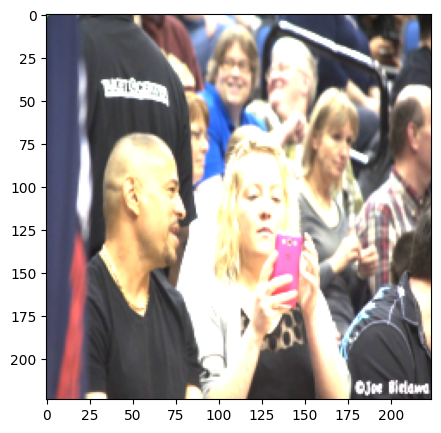

In [16]:
sample_image= train_dataset[8]['image']
sample_label= train_dataset[8]['boxes']

np_image_display= sample_image.detach().cpu().numpy()
np_image_display = np.transpose(np_image_display, (1, 2, 0)) # CxHxW to HxWxC

# Normalize to [0, 255] uint8
if np_image_display.max() <= 1.0:
    np_image_display = (np_image_display * 255).astype(np.uint8)
else:
    np_image_display = np_image_display.astype(np.uint8)

# Ensure contiguous
if not np_image_display.flags['C_CONTIGUOUS']:
    np_image_display = np.ascontiguousarray(np_image_display)

# Draw ALL anchors on the resized image
draw_image_with_box(sample_image, all_anchors)

In [17]:
def filter_valid_bboxes(gt_boxes):
    valid_mask= (gt_boxes.sum(dim=1) > 0) & ((gt_boxes[:, 2] - gt_boxes[:, 0]) > 0) & ((gt_boxes[:, 3] - gt_boxes[:, 1]) > 0)
    return gt_boxes[valid_mask]

def calculate_iou(anchor_boxes, gt_boxes):
    anchor_boxes= anchor_boxes.unsqueeze(1) # Shape: [num_anchors, 1, 4]
    gt_boxes= gt_boxes.unsqueeze(0) # Shape: [1, num_gt_boxes, 4]

    inter_xmin= torch.max(anchor_boxes[:, :, 0], gt_boxes[:, :, 0])
    inter_ymin= torch.max(anchor_boxes[:, :, 1], gt_boxes[:, :, 1])
    inter_xmax= torch.min(anchor_boxes[:, :, 2], gt_boxes[:, :, 2])
    inter_ymax= torch.min(anchor_boxes[:, :, 3], gt_boxes[:, :, 3])

    inter_width= torch.clamp(inter_xmax - inter_xmin, min= 0)
    inter_height= torch.clamp(inter_ymax - inter_ymin, min= 0)
    inter_area= inter_width * inter_height

    anchor_area= (anchor_boxes[:, :, 2] - anchor_boxes[:, :, 0]) * (anchor_boxes[:, :, 3] - anchor_boxes[:, :, 1])
    gt_area= (gt_boxes[:, :, 2] - gt_boxes[:, :, 0]) * (gt_boxes[:, :, 3] - gt_boxes[:, :, 1])
    union_area= anchor_area + gt_area - inter_area

    iou= inter_area / (union_area + 1e-6)
    return iou

In [18]:
def match_anchors_to_gt(anchor_boxes, gt_boxes, iou_high_threshold=0.7, iou_low_threshold=0.2, 
                        device='cpu', num_samples=128, positive_ratio=0.5):
    gt_boxes = filter_valid_bboxes(gt_boxes)
    num_anchors = anchor_boxes.shape[0]
    
    if gt_boxes.numel() == 0:
        labels = torch.full((num_anchors,), -1, dtype=torch.int32, device=device)
        regression_targets = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
        return {"labels": labels, "regression_targets": regression_targets}

    anchor_boxes = anchor_boxes.to(device)
    gt_boxes = gt_boxes.to(device)
    
    iou_matrix = calculate_iou(anchor_boxes, gt_boxes)
    max_iou, max_iou_indices = iou_matrix.max(dim=1)
    
    # Initial label assignment
    labels = torch.full((num_anchors,), -1, dtype=torch.int32, device=device)
    labels[max_iou >= iou_high_threshold] = 1
    labels[max_iou < iou_low_threshold] = 0
    
    # Ensure each GT has at least one positive anchor
    for i in range(gt_boxes.shape[0]):
        best_anchor_idx = iou_matrix[:, i].argmax()
        labels[best_anchor_idx] = 1
    
    # Sample positive and negative anchors
    positive_indices = torch.where(labels == 1)[0]
    negative_indices = torch.where(labels == 0)[0]
    
    num_positive = min(int(num_samples * positive_ratio), positive_indices.numel())
    num_negative = min(num_samples - num_positive, negative_indices.numel())
    
    # Sample positives
    if positive_indices.numel() > num_positive:
        positive_indices = positive_indices[torch.randperm(positive_indices.numel())[:num_positive]]
    
    # Sample negatives
    if negative_indices.numel() > num_negative:
        negative_indices = negative_indices[torch.randperm(negative_indices.numel())[:num_negative]]
    
    # Create final labels (only sampled anchors are used for training)
    final_labels = torch.full((num_anchors,), -1, dtype=torch.int32, device=device)
    final_labels[positive_indices] = 1
    final_labels[negative_indices] = 0
    
    # Compute regression targets
    regression_targets = torch.zeros((num_anchors, 4), dtype=torch.float32, device=device)
    if positive_indices.numel() > 0:
        positive_anchors = anchor_boxes[positive_indices]
        corresponding_gt_boxes = gt_boxes[max_iou_indices[positive_indices]]
        
        # Convert to center coordinates
        anchor_widths = positive_anchors[:, 2] - positive_anchors[:, 0]
        anchor_heights = positive_anchors[:, 3] - positive_anchors[:, 1]
        anchor_centers_x = positive_anchors[:, 0] + 0.5 * anchor_widths
        anchor_centers_y = positive_anchors[:, 1] + 0.5 * anchor_heights
        
        gt_widths = corresponding_gt_boxes[:, 2] - corresponding_gt_boxes[:, 0]
        gt_heights = corresponding_gt_boxes[:, 3] - corresponding_gt_boxes[:, 1]
        gt_centers_x = corresponding_gt_boxes[:, 0] + 0.5 * gt_widths
        gt_centers_y = corresponding_gt_boxes[:, 1] + 0.5 * gt_heights
        
        # Parameterized regression targets
        regression_targets[positive_indices, 0] = (gt_centers_x - anchor_centers_x) / anchor_widths
        regression_targets[positive_indices, 1] = (gt_centers_y - anchor_centers_y) / anchor_heights
        regression_targets[positive_indices, 2] = torch.log(gt_widths / anchor_widths + 1e-8)
        regression_targets[positive_indices, 3] = torch.log(gt_heights / anchor_heights + 1e-8)
    
    return {"labels": final_labels, "regression_targets": regression_targets}

In [19]:
filtered_bboxes= filter_valid_bboxes(sample_label)
iou= calculate_iou(all_anchors, filtered_bboxes)
all_anchors.shape, iou.shape, filtered_bboxes.shape
max_iou, max_iou_indices= iou.max(dim= 1)
matched_targs= match_anchors_to_gt(all_anchors, sample_label)
matched_labels, regression_targets= matched_targs['labels'], matched_targs['regression_targets']
num_positive_labels= torch.sum(matched_labels==1)
num_positive_labels, iou.max()

(tensor(1), tensor(0.))

In [20]:
torch.where(matched_labels == 0)[0].shape

torch.Size([127])

In [21]:
def visualize_anchors_and_gt(image, anchors, gt_boxes):
    # Convert image tensor to NumPy
    np_image = image.detach().cpu().numpy()
    np_image = np.transpose(np_image, (1, 2, 0))  # Convert [C, H, W] to [H, W, C]
    image_width, image_height= np_image.shape[:2]
    if np_image.max() > 1.0:
        np_image= np_image / 255.0

    np_image= np.clip(np_image, 0.0, 1.0)
    np_image = (np_image * 255).astype(np.uint8)  # Scale to [0, 255]
    if not np_image.flags['C_CONTIGUOUS']:
        np_image= np.ascontiguousarray(np_image)
    # Draw anchors
    for anchor in anchors:
        ymin, xmin, ymax, xmax= anchor
        xmin= int(xmin * image_width)
        ymin= int(ymin * image_height)
        xmax= int(xmax * image_width)
        ymax= int(ymax * image_height)
        cv2.rectangle(np_image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)  # Green for anchors

    # Draw ground truth boxes
    for box in gt_boxes:
        xmin, ymin, xmax, ymax= box
        xmin= int(xmin * image_width)
        ymin= int(ymin * image_height)
        xmax= int(xmax * image_width)
        ymax= int(ymax * image_height)
        cv2.rectangle(np_image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)  # Red for ground truth

    # Display the image
    plt.figure(figsize=(8, 7))
    plt.imshow(np_image)
    plt.title("Anchors and Ground Truth Boxes")
    plt.axis("off")
    plt.show()


In [22]:
sample_image.shape

torch.Size([3, 224, 224])

In [23]:
positive_indices= torch.where(matched_labels == 1)[0]
positive_indices

tensor([0])

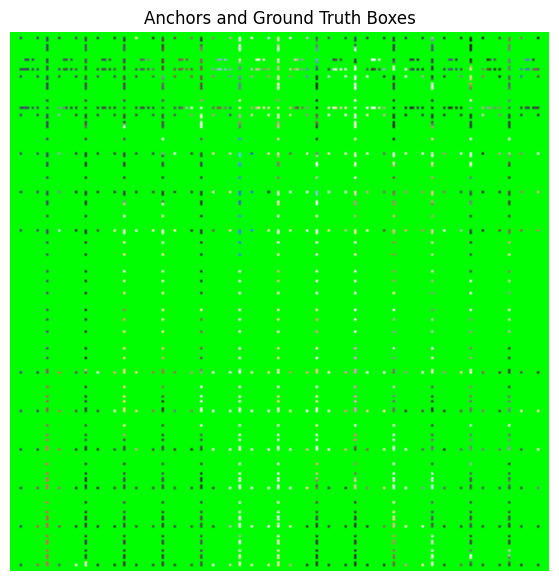

In [24]:
visualize_anchors_and_gt(sample_image, all_anchors, filtered_bboxes)